In [775]:
# https://www.analyticsvidhya.com/blog/2021/04/concrete-strength-prediction-using-machine-learning-with-python-code/
# https://www.kaggle.com/elikplim/concrete-compressive-strength-data-set
# https://pyro.ai/examples/gp.html
# https://docs.pyro.ai/en/stable/contrib.gp.html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm

import torch

import os
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(0)

from datetime import datetime

import matplotlib as mpl
from matplotlib import rc
mpl.rcParams['font.family'] = ['times new roman'] # default is sans-serif
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
datetime = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

- Gaussian Process Regression for concrete mix design parameters and concrete property (compressive strength).
- Input feature space is 8 dimentional.
- RBF kernel is used
- Number of training data points is N ~ 700
- Number of test data points is ~ 300.
- Once learned the GP will act as surrogate. 



## Reading and Analyzing Experimental Data

In [459]:
df = pd.read_csv('../Data/concrete_data.csv')

In [460]:
# Joerg :  Age has exponential relation
df['age']= np.log(df['age'])

In [418]:
df

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength,log_age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,3.332205
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,3.332205
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,5.598422
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,5.899897
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,5.886104
...,...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,3.332205
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,3.332205
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,3.332205
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,3.332205


In [ ]:
df.describe()

In [ ]:
df.isnull().sum()
df.info()

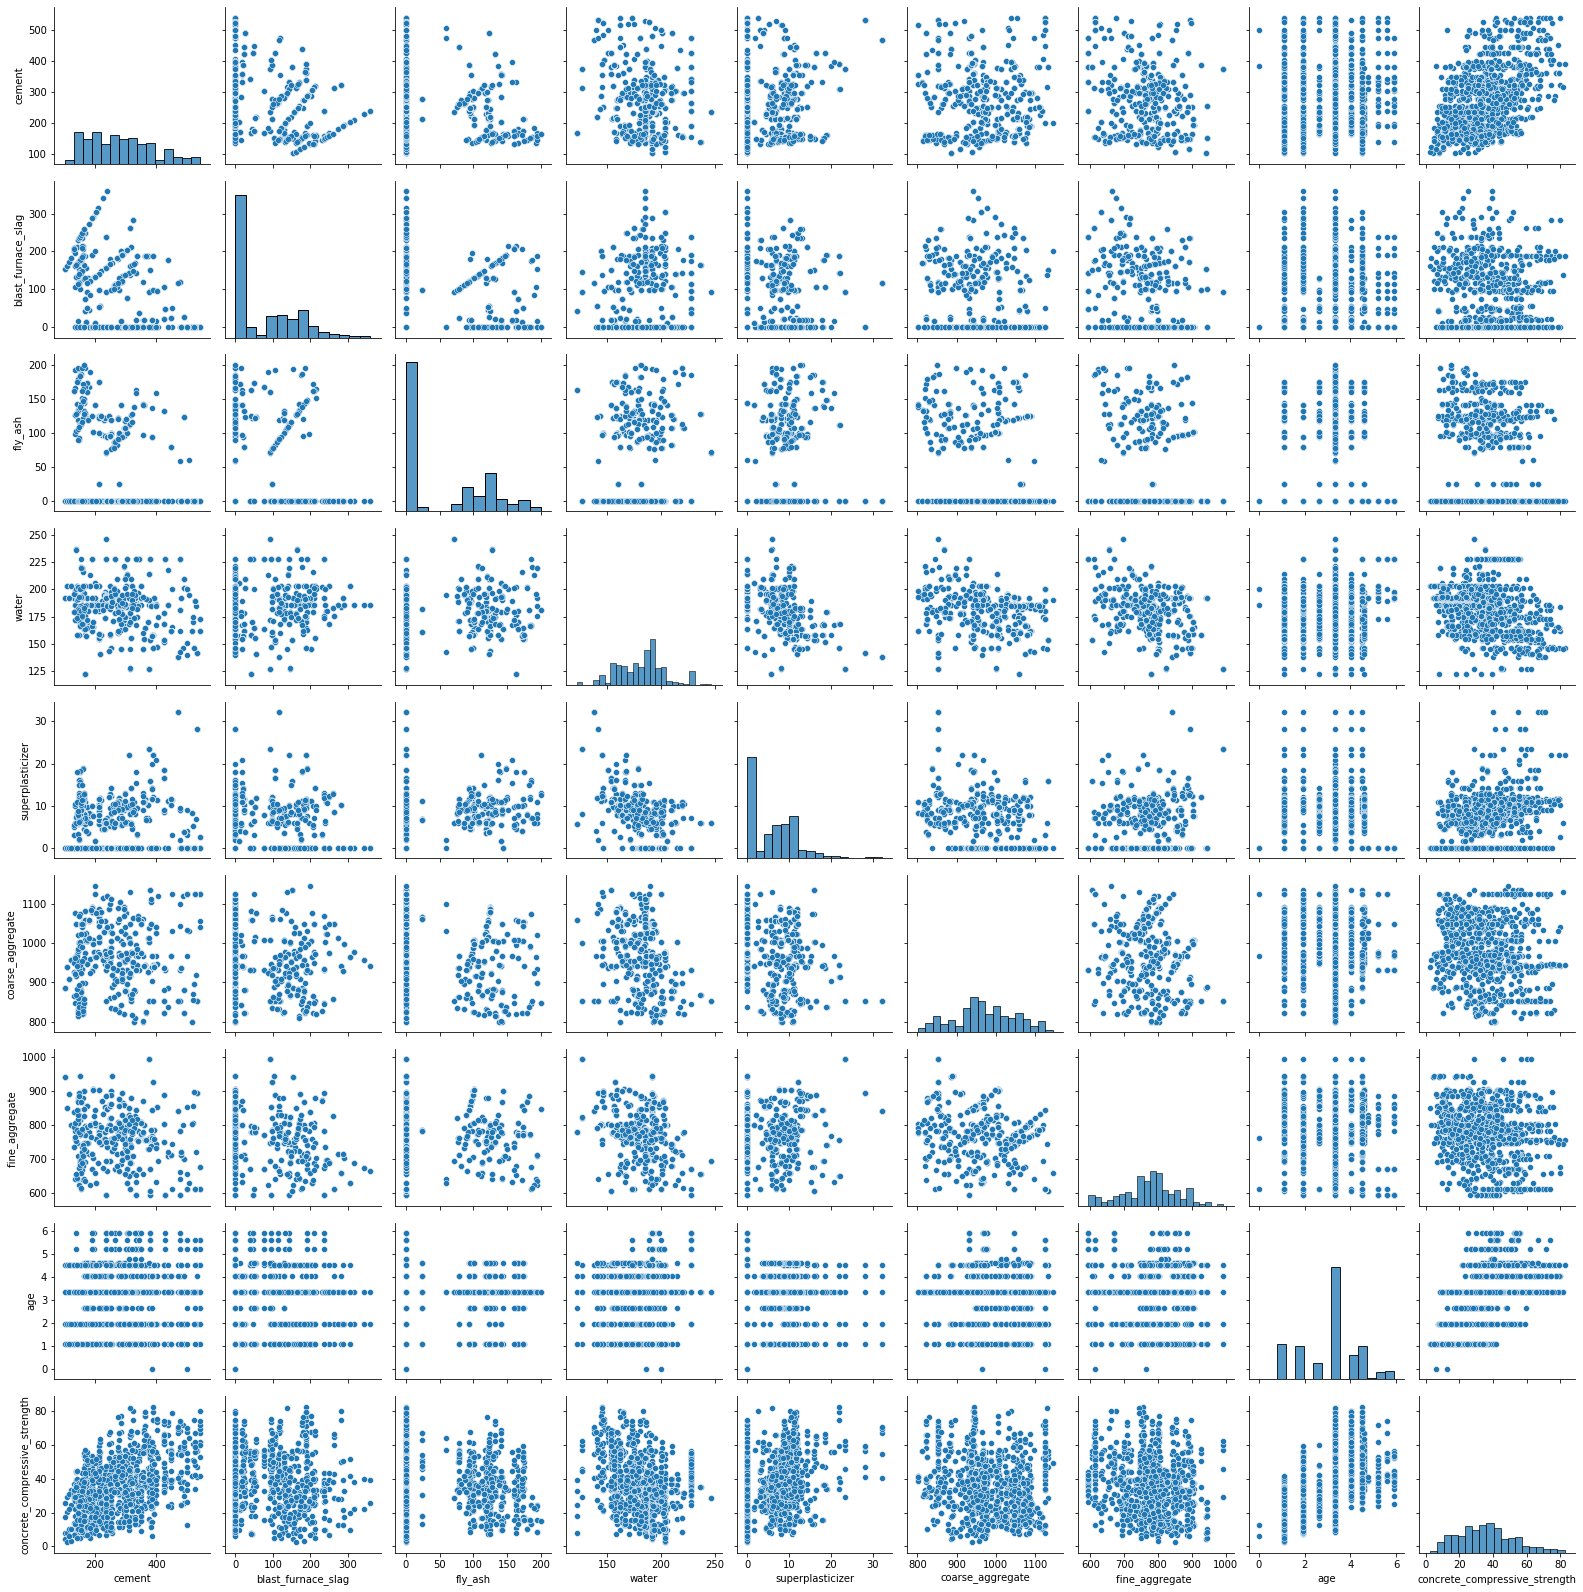

In [5]:
sb.pairplot(df)
plt.savefig('./Figs/Pairplot',format='pdf')

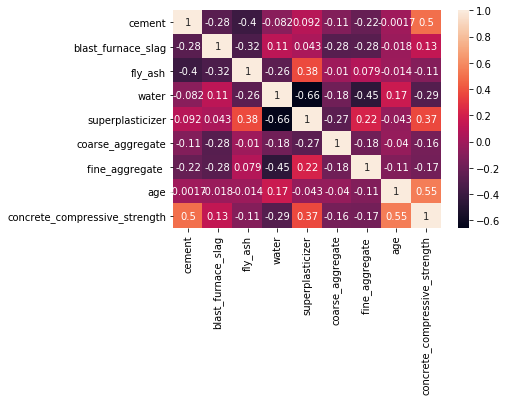

In [5]:
sb.heatmap(df.corr(),annot=True)
#plt.tight_layout()
plt.savefig('Correlation_heatmap',format='pdf')


In [766]:
# independent variables
x = df.drop(['concrete_compressive_strength'],axis=1)
# dependent variables
y = df['concrete_compressive_strength']

## Gaussian Process Regression
- log normal prior for RBF kernel variance and length scale
- inferred these by optimising ELBO with ADAM.
- ARD type prior for length scale ie $\textbf{L} = diag(l_i)$ and inverse gamma prior for each

In [462]:
from sklearn.model_selection import train_test_split
# TODO: k fold cross validation test.
xtrain,xtest,ytrain,ytest= train_test_split(x,y,test_size=0.3,random_state=42)

In [5]:
# from sklearn.preprocessing import StandardScaler
# stand= StandardScaler()
# Fit = stand.fit(xtrain)
# xtrain_scl_chk = Fit.transform(xtrain) #721x8
# xtest_scl_chk = Fit.transform(xtest) #309x8

In [440]:
# not in active use
class TorchStandardScaler:
    def fit(self, x):
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x -= self.mean
        x /= (self.std + 1e-7)
        return x
    def inverse_transform(self,x):
        tmp = x*self.std + self.mean
        return tmp



In [463]:
scalar = TorchStandardScaler()
Fit = scalar.fit(torch.tensor(np.array(xtrain)))
xtrain_scl = scalar.transform(torch.tensor(np.array(xtrain)))
xtest_scl = scalar.transform(torch.tensor(np.array(xtest)))

In [8]:
# testing for different length scale for feature space
feature_space_input_dim = np.shape(xtrain_scl)[1]
kernel = gp.kernels.RBF(input_dim=feature_space_input_dim, variance=torch.tensor(1.),
                        lengthscale=torch.ones(feature_space_input_dim))
gpr = gp.models.GPRegression(xtrain_scl, torch.tensor(ytrain.array), kernel, noise=torch.tensor(1.))
#gpr = gp.models.GPRegression(torch.tensor(xtrain_scl), torch.tensor(ytrain.array), kernel, noise=torch.tensor(1.)) # this is observational noise

In [9]:
# note that our priors have support on the positive reals
# https://pyro.ai/examples/tensor_shapes.html
# https://ericmjl.github.io/blog/2019/5/29/reasoning-about-shapes-and-probability-distributions/
# to event converts to multivariate

# choosing hyperprior. Inverse gamma for length scale and gamma for inverse of lengthscale. Gamma promoted l --> inf thus weeding out input which doesnt affect output. 
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.InverseGamma(2*torch.ones(feature_space_input_dim), 1.0).to_event())  
gpr.kernel.variance = pyro.nn.PyroSample(dist.InverseGamma(2.0, 1.0))
#gpr.noise = pyro.nn.PyroSample(dist.Uniform(1.0, 30.0))
gpr.noise = pyro.nn.PyroSample(dist.InverseGamma(2.0, 1.0))

In [10]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=1)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
grad = []
num_steps = 1000 if not smoke_test else 2

for epoch in range(6):
    for i in tqdm(range(num_steps)):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        tmp = 0
        # Note these are reparametrized values
        for p in gpr.parameters():
            #print(p.grad)
            tmp+=torch.norm(p.grad)**2
        grad.append(tmp.sqrt())
    scheduler.step()

100%|██████████| 1000/1000 [01:08<00:00, 14.70it/s]


In [11]:
def training_diagnostics(obj_value,Yaxis_obj, grad,Yaxis_grad, save = False, path =None, Name = None):
    """
    """
    fig = plt.figure(figsize=(12, 6))
    #plt.subplots_adjust(wspace=0.3, hspace=0.5)

    # plot the sampled values as functions of x_star
    plt.subplot(2, 2, 1)
    plt.semilogy(obj_value);
    plt.xlabel("iteration")
    plt.ylabel(Yaxis_obj)

    # visualise the covariance function
    plt.subplot(2, 2, 2)
    plt.semilogy(grad);
    plt.xlabel("iteration")
    plt.ylabel(Yaxis_grad)
    
    if save == True:
        plt.savefig(path + Name,format='pdf')
        

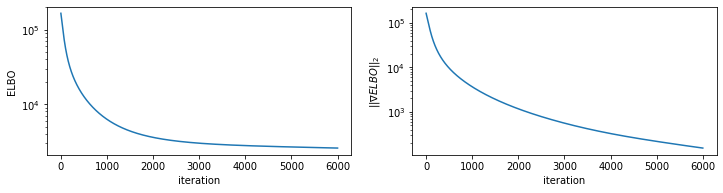

In [12]:
training_diagnostics(losses,"ELBO",grad,r"$||\nabla ELBO||_2$", save = True,path ='./Figs/',Name = 'GP training Diagnostics')

In [410]:
 for p in gpr.parameters():
    print(p)

Parameter containing:
tensor(3.6637, requires_grad=True)
Parameter containing:
tensor([0.8899, 1.2422, 1.4895, 1.4623, 1.6577, 1.9022, 1.6573, 0.8225],
       requires_grad=True)
Parameter containing:
tensor(3.3656, requires_grad=True)


In [17]:
gpr.set_mode('model')
print('variance = {}'.format(gpr.kernel.variance))
print('lengthscale = {}'.format(gpr.kernel.lengthscale))
print('noise = {}'.format(gpr.noise))


variance = 0.45619794726371765
lengthscale = tensor([0.2303, 0.5190, 0.2572, 0.6098, 1.1104, 0.5189, 0.4048, 1.5165])
noise = 0.9089469909667969


In [411]:
# tell gpr that we want to get samples from guides
# This is the learned parameters. 
gpr.set_mode('guide')
print('variance = {}'.format(gpr.kernel.variance))
print('lengthscale = {}'.format(gpr.kernel.lengthscale))
print('noise = {}'.format(gpr.noise))

variance = 28.951465606689453
lengthscale = tensor([2.4349, 3.4631, 4.4349, 4.3157, 5.2475, 6.7007, 5.2451, 2.2761],
       grad_fn=<ExpandBackward>)
noise = 39.00471115112305


## Prediction and Visualization

In [15]:
y_pred_mean, y_pred_cov = gpr(xtest_scl, full_cov =True, noiseless = False) # Remove or include observational noise in prediction?


Text(0.5, 1.0, 'Posterior Covarience')

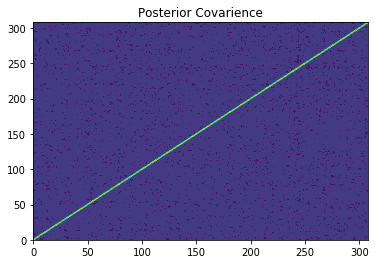

In [16]:
plt.contourf(y_pred_cov.detach().numpy())
plt.title("Posterior Covarience")
#plt.savefig('Pos_Covariance_kernel',format='pdf')

In [ ]:
def Viz_input_feature_vs_output(title):
    fig = plt.figure(figsize=(12, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    for i in range(8):
        plt.subplot(4,4,i+1)
        plt.plot(xtest_scl[:,i], y_pred_mean.detach().numpy(),"*",label="Pred. values")
        plt.plot(xtest_scl[:,i], ytest,"+",label="Exp. values")
        plt.ylabel("comp_strength")
        plt.xlabel("$X_%i$"%(i+1))
    plt.title(title)
    plt.legend()

In [ ]:
Viz_input_feature_vs_output("Compressive strength vs input features")

In [ ]:
#z = pyro.distributions.MultivariateNormal(y_pred_mean,covariance_matrix=y_pred_cov).rsample([1000])

Text(0.5, 1.0, 'Comparing predicted compressive strength for new experiments')

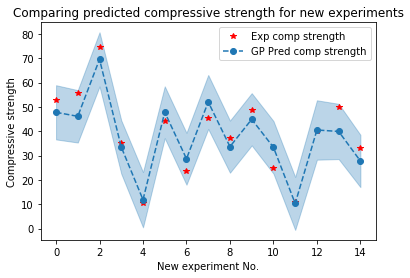

In [17]:
n_test=15
x = np.arange(np.shape(ytest[:n_test])[0])
plt.plot(x,ytest[:n_test],'r*',label="Exp comp strength")

plt.plot(x, y_pred_mean.detach().numpy()[:n_test], '-o',label="GP Pred comp strength",ls='--')  # plot the mean

sd = y_pred_cov.diag().sqrt()
plt.fill_between(x,  # plot the two-sigma uncertainty about the mean
                 (y_pred_mean - 2.0 * sd).detach().numpy()[:n_test],
                 (y_pred_mean + 2.0 * sd).detach().numpy()[:n_test],
                 color='C0', alpha=0.3)
plt.legend()
plt.xlabel("New experiment No.")
plt.ylabel("Compressive strength")
plt.title("Comparing predicted compressive strength for new experiments")


#plt.errorbar(x,y_pred_mean.detach().numpy()[:n_test],yerr=2*sd[:n_test],fmt='o', color='black',
#             ecolor='lightgray', elinewidth=3, alpha =0.5)
#plt.savefig('Posterior_predictive',format='pdf')

Text(0.5, 0, 'compressive strength (experiment)')

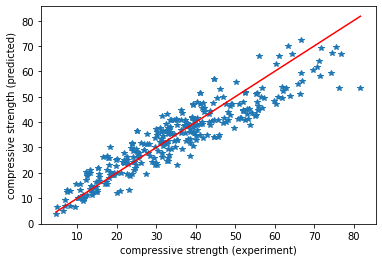

In [17]:
plt.plot(ytest,y_pred_mean.detach_().numpy(),"*")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red')
plt.ylabel('compressive strength (predicted)')
plt.xlabel('compressive strength (experiment)')
#plt.savefig('./Figs/Observed_vs_predicted',format='pdf')

In [18]:
from sklearn.metrics import r2_score
cod = r2_score(ytest,y_pred_mean.detach().numpy())
print ("The coefficient of Determination is %2.3f" % cod)

The coefficient of Determination is 0.845


In [ ]:
# from sklearn.model_selection import cross_val_score, KFold
# K = 20  # folds
# R2 = cross_val_score(gpr, x, y=y, cv=KFold(y.size, K), n_jobs=1).mean()
# print("The %d-Folds estimate of the coefficient of determination is R2 = %s"
#       % (K, R2))

### Walz curve predictions and comparrison with test data and the GP surrogate

In [20]:
# w/z < 1 is useless. So chucking those out. Also keeping just 28 days strength as walz curve is just defined for that

idx_N28_w_z_1 = np.where((np.array(xtest['age'])==np.log(28)) & (np.array(xtest['water'])/np.array(xtest['cement'])<1))[0]

In [21]:
# choosing which walz will represent the data in best possible way
N28 = [62.5,52.5,42.5]
y_walz_allclass = {
'62.5': N28[0]*(2.823-4.785*(np.array(xtest['water'])[idx_N28_w_z_1]/np.array(xtest['cement'])[idx_N28_w_z_1])+2.334*(np.array(xtest['water'])[idx_N28_w_z_1]/np.array(xtest['cement'])[idx_N28_w_z_1])**2),
'52.5': N28[1]*(2.587-4.109*(np.array(xtest['water'])[idx_N28_w_z_1]/np.array(xtest['cement'])[idx_N28_w_z_1])+1.873*(np.array(xtest['water'])[idx_N28_w_z_1]/np.array(xtest['cement'])[idx_N28_w_z_1])**2),
'42.5': N28[2]*(2.769-4.581*(np.array(xtest['water'])[idx_N28_w_z_1]/np.array(xtest['cement'])[idx_N28_w_z_1])+2.154*(np.array(xtest['water'])[idx_N28_w_z_1]/np.array(xtest['cement'])[idx_N28_w_z_1])**2)
}

In [22]:
for i,v in y_walz_allclass.items():
    cod_walz = r2_score(np.array(ytest)[idx_N28_w_z_1],v)
    print ("The coefficient of Determination for N28 %s is %2.3f" % (i, cod_walz))


The coefficient of Determination for N28 62.5 is -0.135
The coefficient of Determination for N28 52.5 is 0.371
The coefficient of Determination for N28 42.5 is 0.128


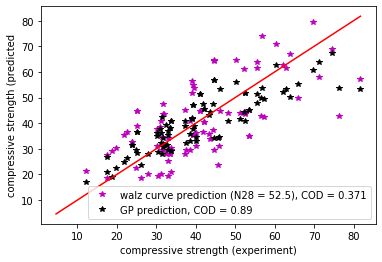

In [23]:
# observed vs pred figure for walz curve
plt.plot(np.array(ytest)[idx_N28_w_z_1],y_walz_allclass['52.5'],"m*", label = 'walz curve prediction (N28 = 52.5), COD = 0.371')
plt.plot(np.array(ytest)[idx_N28_w_z_1],y_pred_mean.detach_().numpy()[idx_N28_w_z_1],"k*", label = 'GP prediction, COD = 0.89')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red')
plt.ylabel('compressive strength (predicted)')
plt.xlabel('compressive strength (experiment)')
plt.legend()
#plt.savefig('./Figs/Observed_vs_walzCurvepredicted',format='pdf')

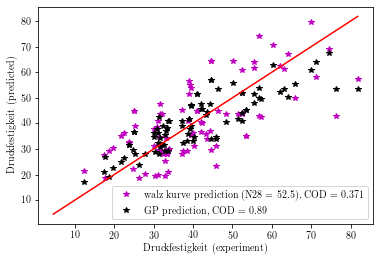

In [494]:
## for GERMAN
# observed vs pred figure for walz curve
plt.plot(np.array(ytest)[idx_N28_w_z_1],y_walz_allclass['52.5'],"m*", label = 'walz kurve prediction (N28 = 52.5), COD = 0.371')
plt.plot(np.array(ytest)[idx_N28_w_z_1],y_pred_mean.detach_().numpy()[idx_N28_w_z_1],"k*", label = 'GP prediction, COD = 0.89')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red')
plt.ylabel('Druckfestigkeit (predicted)')
plt.xlabel('Druckfestigkeit (experiment)')
plt.legend()

plt.savefig('./Figs/Observed_vs_walzCurvepredicted_german'+datetime,format='pdf')

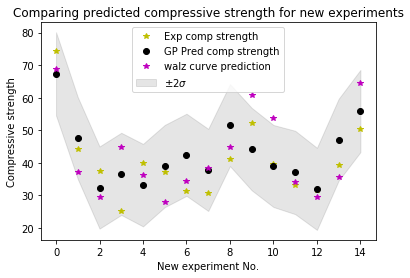

In [28]:
# Predicted vs new exp number (test data)
n_test=15
x = np.arange(np.shape(ytest[:n_test])[0])
plt.plot(x,np.array(ytest)[idx_N28_w_z_1[:n_test]],'y*',label="Exp comp strength")

plt.plot(x, y_pred_mean.detach().numpy()[idx_N28_w_z_1[:n_test]], 'o',label="GP Pred comp strength",color='black')  # plot the mean

sd = y_pred_cov.diag().sqrt()
plt.fill_between(x,  # plot the two-sigma uncertainty about the mean
                 (y_pred_mean - 2.0 * sd).detach().numpy()[idx_N28_w_z_1[:n_test]],
                 (y_pred_mean + 2.0 * sd).detach().numpy()[idx_N28_w_z_1[:n_test]],
                 color='black', alpha=0.1, label="$\pm 2 \sigma$")
plt.plot(x,y_walz_allclass['52.5'][:n_test],'m*',label="walz curve prediction")
plt.legend()
plt.xlabel("New experiment No.")
plt.ylabel("Compressive strength")
plt.title("Comparing predicted compressive strength for new experiments")


#plt.errorbar(x,y_pred_mean.detach().numpy()[idx_N28_w_z_1[:n_test]],yerr=2*sd[idx_N28_w_z_1[:n_test]],fmt='o', color='black',
#             ecolor='lightgray', capsize=3,label="GP Druckfestigkeit")
plt.savefig('./Figs/Posterior_predictive_wrt_walz'+ datetime,format='pdf')

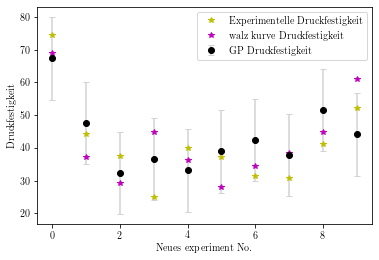

In [493]:
## GERMAN VERSION
# Predicted vs new exp number (test data)
n_test=10
x = np.arange(np.shape(ytest[:n_test])[0])
plt.plot(x,np.array(ytest)[idx_N28_w_z_1[:n_test]],'y*',label="Experimentelle Druckfestigkeit")

#plt.plot(x, y_pred_mean.detach().numpy()[idx_N28_w_z_1[:n_test]], 'o',label="GP Druckfestigkeit",color='black')  # plot the mean

sd = y_pred_cov.diag().sqrt()
# plt.fill_between(x,  # plot the two-sigma uncertainty about the mean
#                  (y_pred_mean - 2.0 * sd).detach().numpy()[idx_N28_w_z_1[:n_test]],
#                  (y_pred_mean + 2.0 * sd).detach().numpy()[idx_N28_w_z_1[:n_test]],
#                  color='black', alpha=0.1, label="$\pm 2 \sigma$")
plt.errorbar(x,y_pred_mean.detach().numpy()[idx_N28_w_z_1[:n_test]],yerr=2*sd[idx_N28_w_z_1[:n_test]],fmt='o', color='black',
             ecolor='lightgray', capsize=3,label="GP Druckfestigkeit")
plt.plot(x,y_walz_allclass['52.5'][:n_test],'m*',label="walz kurve Druckfestigkeit")
plt.legend()
plt.xlabel("Neues experiment No.")
plt.ylabel("Druckfestigkeit")
#plt.title("Comparing predicted compressive strength for new experiments")



plt.savefig('./Figs/Posterior_predictive_wrt_walz_german'+ datetime,format='pdf')

In [54]:
# GP testing with training data
n_test= 50
w_by_c = np.array(xtrain['water'])[:n_test]/np.array(xtrain['cement'])[:n_test]
y_exp_plot = np.array(ytrain)[:n_test]
y_pred_mean_train, y_pred_cov_train = gpr(torch.tensor(xtrain_scl), full_cov =True, noiseless = False)
y_GP_plot = y_pred_mean_train.detach().numpy()[:n_test]
sd = y_pred_cov_train.diag().sqrt()
y_GP_sd_plot = sd.detach().numpy()[:n_test]

<ipython-input-54-2acc550e2f62>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_mean_train, y_pred_cov_train = gpr(torch.tensor(xtrain_scl), full_cov =True, noiseless = False)


Text(0.5, 1.0, 'Comparing compressive strength for w/z')

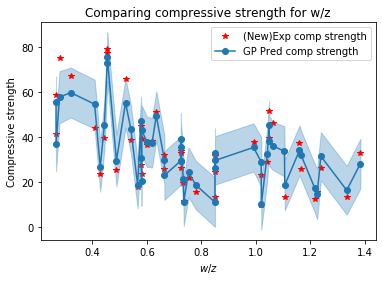

In [55]:
idx_tmp = np.argsort(w_by_c)
plt.plot(np.sort(w_by_c),y_exp_plot[idx_tmp],'r*',label="(New)Exp comp strength")
plt.plot(np.sort(w_by_c),y_GP_plot[idx_tmp],'-o',label="GP Pred comp strength")
#sd = np.sqrt(y_GP_var_plot[idx_tmp])

plt.fill_between(np.sort(w_by_c),  # plot the two-sigma uncertainty about the mean
                 (y_GP_plot[idx_tmp] - 2.0 * y_GP_sd_plot[idx_tmp]),
                 (y_GP_plot[idx_tmp] + 2.0 * y_GP_sd_plot[idx_tmp]),
                 color='C0', alpha=0.3)

#plt.errorbar(np.sort(w_by_c),y_GP_plot[idx_tmp],yerr=2*sd,fmt='o', color='blue',
#             ecolor='lightgray', elinewidth=3,alpha = 0.7, label="GP Pred comp strength $\pm 2 \sigma$")
plt.legend()
plt.xlabel("$w/z$")
plt.ylabel("Compressive strength")
plt.title("Comparing compressive strength for w/z")


In [25]:
# GP testing with test data

n_test= 15
w_by_c = np.array(xtest['water'])[idx_N28_w_z_1[:n_test]]/np.array(xtest['cement'])[idx_N28_w_z_1[:n_test]]
y_exp_plot = np.array(ytest)[idx_N28_w_z_1[:n_test]]
y_GP_plot = y_pred_mean.detach().numpy()[idx_N28_w_z_1[:n_test]]
sd = y_pred_cov.diag().sqrt()
y_GP_sd_plot = sd.detach().numpy()[idx_N28_w_z_1[:n_test]]
y_walz_plot = y_walz_allclass['52.5'][:n_test]

Text(0.5, 1.0, 'Comparing compressive strength for w/z')

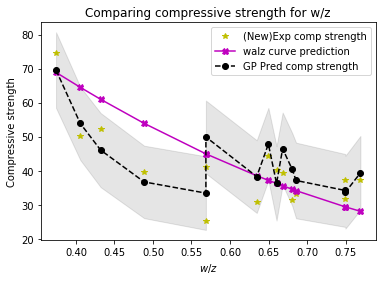

In [26]:
idx_tmp = np.argsort(w_by_c)
plt.plot(np.sort(w_by_c),y_exp_plot[idx_tmp],'y*',label="(New)Exp comp strength")
plt.plot(np.sort(w_by_c),y_walz_plot[idx_tmp],'m-X',label = "walz curve prediction")
plt.plot(np.sort(w_by_c),y_GP_plot[idx_tmp],'k-o',label="GP Pred comp strength",ls='--')
#sd = np.sqrt(y_GP_var_plot[idx_tmp])

plt.fill_between(np.sort(w_by_c),  # plot the two-sigma uncertainty about the mean
                 (y_GP_plot[idx_tmp] - 2.0 * y_GP_sd_plot[idx_tmp]),
                 (y_GP_plot[idx_tmp] + 2.0 * y_GP_sd_plot[idx_tmp]),
                 color='black', alpha=0.1)

#plt.errorbar(np.sort(w_by_c),y_GP_plot[idx_tmp],yerr=2*sd,fmt='o', color='blue',
#             ecolor='lightgray', elinewidth=3,alpha = 0.7, label="GP Pred comp strength $\pm 2 \sigma$")
plt.legend()
plt.xlabel("$w/z$")
plt.ylabel("Compressive strength")
plt.title("Comparing compressive strength for w/z")


### Open quesarrayns/Discussions:
- The coefficeint of determination (~0.85) looks acceptable. But again that depends on the variabiliuty of the new unseen experiment performed.
- The input feature space is continous. There can be discrete input also (switch on/off, parameters bound to take specific values), which would require a different kind of kernel.
- Is RBF a good choice for kernel in this case?
- what hyperprior shpuld be selected for kernal variance, length scale and observational noise?
- Choosing starting values for RBF variance, length scale and observational noise?
- Same length scale for all the eight input feature space? Or should I take different? The inputs are normalized before learning anyhow.
-  Many features have zero values. Are they corrupting the predictions?


## Optimisation of posterior Mean wrt input
- what input parameters will maximise the comp strnegth. to start with cement and water content can be tweaked and others kept constant.

In [ ]:
import copy
cement = []
water = []
mean_comp_strength = []
x_tmp = copy.deepcopy(xtest_scl)
def obj(X_new):
    """
    gpr_model : GP object
    X_new : vector of new inputs
    """
    
    x_tmp[0,0]= X_new[0]  #apending with cement
    x_tmp[0,3]= X_new[1]
    #print(xtest_scl[0,:])
    mean, var = gpr(torch.unsqueeze(torch.tensor(x_tmp[0,:]),0), full_cov =True, noiseless = False)
    cement.append(X_new[0])
    water.append(X_new[1])
    mean_comp_strength.append(mean)
    return 1/mean.detach().numpy()

In [ ]:
from scipy.optimize import minimize
pt = [-0.1,1.0]
result = minimize(obj,pt,method='Nelder-Mead')

In [ ]:
solution = result['x']
evaluation = obj(solution)
print('Solution: f(%s) = %.5f' % (solution, 1/evaluation))

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1,2,1)
plt.plot(cement,mean_comp_strength,'r')
plt.plot(xtest_scl[0,0],ytest.array[0],'*', label = 'Experiment')
plt.axvline(x=solution[0],label="$x_{opt}$")
plt.legend()
plt.xlabel('Cement')
plt.ylabel('comp strength')

plt.subplot(1,2,2)
plt.plot(water,mean_comp_strength,'r')
plt.plot(xtest_scl[0,3],ytest.array[0],'*',label = 'Experiment')
plt.axvline(x=solution[1],label="$x_{opt}$")
plt.legend()
plt.xlabel('Water')

plt.title('$Y$ vs $X_1$ and $X_2$ fixing all other inputs')

## 

# 2. Constrained optimisation
arg min J(X) st h(X) = 0       (with J(X)=x_1 and h(X) = (p(y<50|X) < 0.05) (x_1 being cement and Y compressive str.)

In [ ]:
# from scipy.stats import norm
# class constrained_optimisation:
#     def __init__(self,X,gpr,y_min,prob,i):
#         """
#         X [Nxq] : the input features
#         gpr : the GP surrogate base class
#         y_min : The chance to attain this comp strength value is prob*100% or less. The minimum comp str that should be attained
#         prob : 
#         i : index of input which needs to be minimised
#         """
        
#         self.X = torch.unsqueeze(torch.tensor(X),0)
#         #self.X = X
#         self.gpr = gpr
#         self.y_min = y_min
#         self.prob = prob
#         self.i=i
    
#     def obj_cons_opt(self,X):
#         return X[:,self.i]

#     def constraint(self,X):
#         m,v = self.gpr(self.X, full_cov =True, noiseless = False)
#         p = norm.cdf(self.y_min,loc=m.detach().numpy(),scale = np.sqrt(v.detach().numpy()))
#         return p
#     def optimizer():
#         raise NotImplementedError
        
    
        

In [ ]:
# c_opt = constrained_optimisation(xtest_scl[0,:],gpr,50,0.05,0)

In [ ]:
# c_opt.constraint(c_opt.X)

## 2.1 Naive quick implimentation
creating grid with X_0(cement) and water(X_3), elauating constraint for all points (keeping all other X fixed) and from points which satisfy constraints,choose smallest X_1.

In [ ]:
# creating mesh grid from X_0 and X_3
# x_c = np.linspace(np.min(xtest_scl[:,0]),np.max(xtest_scl[:,0]),50)
# x_w = np.linspace(np.min(xtest_scl[:,3]),np.max(xtest_scl[:,3]),50)

# X_c, X_w = np.meshgrid(x_c,x_w,indexing='ij')


In [ ]:

# def constraint(X):
#     #x_tmp = Fit.transform(X.reshape(1,-1))
#     m,v = gpr(torch.unsqueeze(torch.tensor(X),0), full_cov =True, noiseless = False)
#     p = norm.cdf(50,loc=m.detach().numpy(),scale = np.sqrt(v.detach().numpy()))
#     return p

In [ ]:
# count = 0
# x_accept_c = []
# x_accept_w = []
# for i in range(x_c.shape[0]):
#     for j in range(x_w.shape[0]):
#         x_tmp = np.array([X_c[i,j],xtest_scl[2,1],xtest_scl[2,2],X_w[i,j],xtest_scl[2,4],xtest_scl[2,5],xtest_scl[2,6],xtest_scl[2,7]])
#         p = constraint(x_tmp)
#         if p <= 0.05:
#             count += 1
#             x_accept_c.append(X_c[i,j])
#             x_accept_w.append(X_w[i,j])
                    

In [ ]:
# choosing min cement values
# x_c_star = np.min(x_accept_c)
# index = np.where(x_accept_c==x_c_star)
# x_w_star = x_accept_w[index[0][0]]

In [ ]:
# plt.plot(X_c,X_w,'b*',alpha=0.5)
# plt.plot(x_accept_c,x_accept_w,'g*',label ='$p(Y\leq50|X)\leq 0.05$')
# plt.plot(xtest_scl[2,0],xtest_scl[2,3],'rx', label = '$x_{exp}$')
# plt.plot(x_c_star,x_w_star,'ko',label='$x^*$')

# plt.xlabel('$X_1$ (Cement)')
# plt.ylabel('$X_4$ (Water)')
# plt.legend()
# plt.savefig('./Figs/Optimised_cementContent_quick',format='pdf')

In [ ]:
# walz curve prediction for x_star
# y_star_walz = 42.5*(2.769-4.581*(x_w_star/x_c_star)+2.154*(x_w_star/x_c_star)**2)

In [ ]:
# y_star_walz

### 2.1.1 temp for unscaled values

In [ ]:
# creating mesh grid from X_0 and X_3
x_c = np.linspace(np.min(xtest['cement']),np.max(xtest['cement']),100)
x_w = np.linspace(np.min(xtest['water']),np.max(xtest['water']),100)

X_c, X_w = np.meshgrid(x_c,x_w,indexing='ij')

In [ ]:
from scipy.stats import norm
def constraint_new(X):
    x_tmp = Fit.transform(X.reshape(1,-1))
    m,v = gpr(torch.tensor(x_tmp), full_cov =True, noiseless = False)
    p = norm.cdf(50,loc=m.detach().numpy(),scale = np.sqrt(v.detach().numpy()))
    return p

In [ ]:
test_exp_no =2
count = 0
x_accept_c = []
x_accept_w = []
xtest_singlexp = np.array(xtest)[test_exp_no,:]
for i in range(x_c.shape[0]):
    for j in range(x_w.shape[0]):
        
        x_tmp = np.array([X_c[i,j],xtest_singlexp[1],xtest_singlexp[2],X_w[i,j],xtest_singlexp[4],xtest_singlexp[5],xtest_singlexp[6],xtest_singlexp[7]])
        p = constraint_new(x_tmp)
        if p <= 0.05:
            count += 1
            x_accept_c.append(X_c[i,j])
            x_accept_w.append(X_w[i,j])

In [ ]:
# choosing min cement values
x_c_star = np.min(x_accept_c)
index = np.where(x_accept_c==x_c_star)
x_w_star = x_accept_w[index[0][2]]

In [ ]:
plt.plot(X_c,X_w,'bo',alpha=0.2)
plt.plot(x_accept_c,x_accept_w,'g*',label ='$p(Y\leq50|X)\leq 0.05$')
plt.plot(xtest_singlexp[0],xtest_singlexp[3],'rx', label = '$x_{exp}$')
plt.plot(x_c_star,x_w_star,'ko',label='$x^*$')

plt.xlabel('$X_1$ (Cement)')
plt.ylabel('$X_4$ (Water)')
plt.legend()
#plt.savefig('./Figs/Optimised_cementContent_quick(unscaled)',format='pdf')

In [ ]:
y_star_walz = 42.5*(2.769-4.581*(x_w_star/x_c_star)+2.154*(x_w_star/x_c_star)**2)

X_star = np.array([x_c_star,xtest_singlexp[1],xtest_singlexp[2],x_w_star,xtest_singlexp[4],xtest_singlexp[5],xtest_singlexp[6],xtest_singlexp[7]])
x_tmp = Fit.transform(X_star.reshape(1,-1))
y_star,v = gpr(torch.tensor(x_tmp), full_cov =True, noiseless = False)


In [ ]:
plt.plot(x_c_star,np.array(ytest)[test_exp_no],'x', label = 'Experiment')
plt.plot(x_c_star,y_star_walz,'g*',label='Walz curve pred')
#plt.plot(x_c_star,y_star.detach().numpy(),'r*')
plt.errorbar(x_c_star,y_star.detach().numpy(),yerr=np.sqrt(v.detach().numpy()),fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, label ='GP prediction')
plt.legend()
plt.xlabel('$X_1^* (Cement)$')
plt.ylabel('Compressive Strength')
plt.savefig('./Figs/Y_star_for_x_star_comparission',format='pdf')

## 2.2 Optimsation with Torch (with penalty term)
$J(X) + \alpha  \textrm{min}(h(X),0.05)$

- \aplha veing small leads to global search, being large lead to local search in the space where constraint is satisfied. A good compromise can be donw with "simulated annealing"
- everything needs to live in the pytorch world for things to be differntiable
- $h(X) = (p(y<50|X) < 0.05)$

TODO:
- 02.01.2021 Scipy constrained optimisation. Need grad from mean and var of GP. Can use gpr.parameters().grad
- Need to add a volume constraint. vol (cement (density = 3.1kg/dm3) + water (d = 1kg/dm3) + fine agreegate (d = 2.6kg/dm3)+ coarse agreegate (d = 2.6kg/dm3)) = 1m3 
       - First just add a penalty term
       - Then try with the scipy
- Try with the basis change what Stelios suggested

https://docs.scipy.org/doc/scipy/tutorial/optimize.html#constrained-minimization-of-multivariate-scalar-functions-minimize

In [56]:

def h_X(X):
    """
    """
    mean, var = gpr(torch.unsqueeze(X,0), full_cov =True, noiseless = False)
    tmp = dist.Normal(mean,torch.sqrt(var))
    return tmp.cdf(torch.tensor(50))

In [83]:
def V_x(X):
    """
    The volume constraint
    """
    # TODO : Detached from the graph. Cant work. Need torch scalar. See above near scikit scalar
    tmp = scalar.inverse_transform(torch.unsqueeze(X,0))
    #print(tmp)
    return tmp[0,0]/3100 + tmp[0,3]/1000 + tmp[0,5]/2600 + tmp[0,6]/2600 -1 

In [58]:
V_x(torch.tensor(np.array(xtest_scl)[2,:]))

tensor([[3.8990e+02, 1.8900e+02, 8.1691e-08, 1.4590e+02, 2.2000e+01, 9.4470e+02,
         7.5580e+02, 3.3322e+00]], dtype=torch.float64)


tensor(-0.0743, dtype=torch.float64)

In [59]:
def J_X(X):
    """
    Need to select first column i.e cement
    
    """
    X_tmp = torch.unsqueeze(X,0)
    return X_tmp[:,0]

In [84]:
def obj(X):
    """
    """
    assert X.requires_grad == True
    # Hard coded 4 known inputs for a certain experiment. 
    X_tmp = torch.hstack((X[0],torch.tensor(xtest_scl[2,1]),torch.tensor(xtest_scl[2,2]),X[1],torch.tensor(xtest_scl[2,4]),X[2],X[3],torch.tensor(xtest_scl[2,7])))
    return J_X(X_tmp) + 10*torch.min(h_X(X_tmp),torch.tensor(0.05)) + V_x(X_tmp)

In [ ]:
def opt_int(X_init,X_exp,opt_index):
    """
    X_init [] Initial values of the optimisation process for the parameters that needs to be optimised
    X_exp [] Fixed values of the parameters, maybe from some experiment
    opt_index : indices that needs to be optimised
    return
    """
    
    
    
    
    
    

In [85]:
#X_para = xtest_scl[2,:]
X_para = xtest_scl[2,[0,3,5,6]]

XX = torch.tensor(X_para,requires_grad =True)
optimizer = torch.optim.Adam([XX], lr=0.01)
losses = []
x_inmdt = []
grad =[]
num_steps = 400 if not smoke_test else 2
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()
    loss = obj(XX)
    loss.backward()
    #print(XX.grad)
    optimizer.step()
    losses.append(loss.item())
    x_inmdt.append(XX)
    grad.append(torch.norm(XX.grad))

<ipython-input-85-95dc27e5d812>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XX = torch.tensor(X_para,requires_grad =True)
  0%|          | 0/400 [00:00<?, ?it/s]<ipython-input-84-805987adc045>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tmp = torch.hstack((X[0],torch.tensor(xtest_scl[2,1]),torch.tensor(xtest_scl[2,2]),X[1],torch.tensor(xtest_scl[2,4]),X[2],X[3],torch.tensor(xtest_scl[2,7])))
100%|██████████| 400/400 [00:31<00:00, 12.79it/s]


In [ ]:
plt.plot(losses);
plt.xlabel("iteration")
plt.ylabel("$J(X) + \lambda min (h(X),0.05)$")

In [ ]:
# plotting L2 norm of gradients
plt.plot(grad)

In [63]:
tmp = np.array(optimizer.param_groups[0]['params'])[0]

In [64]:
X_opt = torch.hstack((tmp[0],torch.tensor(xtest_scl[2,1]),torch.tensor(xtest_scl[2,2]),tmp[1],torch.tensor(xtest_scl[2,4]),tmp[2],tmp[3],torch.tensor(xtest_scl[2,7])))
    

<ipython-input-64-b625b97ae0aa>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_opt = torch.hstack((tmp[0],torch.tensor(xtest_scl[2,1]),torch.tensor(xtest_scl[2,2]),tmp[1],torch.tensor(xtest_scl[2,4]),tmp[2],tmp[3],torch.tensor(xtest_scl[2,7])))


In [65]:
a, b =gpr(torch.unsqueeze(X_opt,0), full_cov =True, noiseless = False)

In [66]:
a

tensor([62.0725], dtype=torch.float64, grad_fn=<AddBackward0>)

In [ ]:
np.array(ytest)[2]

In [75]:
 # Object the scalar needs to be used here
tmp_new = scalar.inverse_transform(X_opt)

In [73]:
XX.shape

torch.Size([4])

In [78]:
tmp_new[0]

tensor([2.9827e+02, 1.8900e+02, 8.1691e-08, 1.4378e+02, 2.2000e+01, 9.9257e+02,
        7.9666e+02, 3.3322e+00], dtype=torch.float64, grad_fn=<SelectBackward>)

In [70]:
np.array(xtest)[2,:]

array([389.9       , 189.        ,   0.        , 145.9       ,
        22.        , 944.7       , 755.8       ,   3.33220451])

In [80]:
V_x(X_opt)

tensor([[2.9827e+02, 1.8900e+02, 8.1691e-08, 1.4378e+02, 2.2000e+01, 9.9257e+02,
         7.9666e+02, 3.3322e+00]], dtype=torch.float64, grad_fn=<AddBackward0>)


tensor(-0.0718, dtype=torch.float64, grad_fn=<SubBackward0>)

### Constraint optimisation with scipy
- https://scipy.github.io/devdocs/tutorial/optimize.html#constrained-minimization-of-multivariate-scalar-functions-minimize
- Using trust region constrained algo
- Pass the Jacobians to it by Torch by calling backward.
- specifically done for test number 2. 


In [389]:
# defining linear volume constraint and bounds

#if bounds are needed the include this
from scipy.optimize import Bounds
lb = [np.array((150-scalar.mean[0][0])/scalar.std[0][0]), np.array((100-scalar.mean[0][1])/scalar.std[0][1]), -np.Inf, -np.Inf]
ub = [np.array((550-scalar.mean[0][0])/scalar.std[0][0]), np.array((250-scalar.mean[0][1])/scalar.std[0][1]), np.Inf, np.Inf]
bounds = Bounds(lb, ub)


from scipy.optimize import LinearConstraint,minimize

# vol (cement (density = 3.1kg/dm3) + water (d = 1kg/dm3) + fine agreegate (d = 2.6kg/dm3)+ coarse agreegate (d = 2.6kg/dm3)) = 1m3
# Info provided 
# lb <= A.dot(x) <= ub, where x are the paramters to be optimised
# x is scaled here so adjusting the linear volume constraints 
# with X unscaled values, sum(X/density) =1 so sum (x*sigma + mu)/density =1; A = [sigma 1/density1, sigma2/density2 .. ]
# lb = ub = [1-sum (mu1/density1 + mu2/density2 .. )]
A = [scalar.std[0][0]/3100, scalar.std[0][3]/1000, scalar.std[0][5]/2600, scalar.std[0][6]/2600]
lb = 1 - (scalar.mean[0][0]/3100 + scalar.mean[0][3]/1000 + scalar.mean[0][5]/2600 + scalar.mean[0][6]/2600) 
linear_constraint = LinearConstraint(A, [lb], [lb])


# For unscaled
#A = [1/3100, 1/1000, 1/2600, 1/2600]
#linear_constraint = LinearConstraint(A, [1], [1])


In [776]:
class ineq_constrain:
    def __init__(self,X_known,min_comp_strength):
        """
        X_opt [tensor] [scaled] [1x4]
        X_known [tensor] [scaled]
        min_comp_strength : The min strength value, the probability to obtain below this is 0.05
        """
        #self.X_opt = X_opt
        self.X_known = X_known
        self.min_comp_strength = min_comp_strength
        
    def cons_f(self,X):
        """
        The cdf ranges from 0 to 1, here the statement says that the strength with value 50Mpa or less should be 5% or less
        x_known [tensor] : Known input or the experiments (scaled values), The *arg takes care of this. 
        X [ndarray] [1,4] scaled values of values to be optimised
        return:
        array [m,]
        """
        if not isinstance(X,torch.Tensor):
            X = torch.tensor(X)
        X_tmp = torch.hstack((X[0],self.X_known[1],self.X_known[2],X[1],self.X_known[4],X[2],X[3],self.X_known[7]))
        #X_tmp = torch.hstack((X[0],torch.tensor(np.array(xtest)[2,1]),torch.tensor(np.array(xtest)[2,2]),X[1],torch.tensor(np.array(xtest)[2,4]),X[2],X[3],torch.tensor(np.array(xtest)[2,7])))
        # normalize it for the GP
        #X_tmp = scalar.transform(torch.unsqueeze(X_tmp,0))
        #mean, var = gpr(X_tmp, full_cov =True, noiseless = False)
        mean, var = gpr(torch.unsqueeze(X_tmp,0), full_cov =True, noiseless = False)
        tmp = dist.Normal(mean,torch.sqrt(var))
        
        if X.requires_grad == True:
            return tmp.cdf(torch.tensor(self.min_comp_strength))
        return tmp.cdf(torch.tensor(self.min_comp_strength)).detach().numpy().reshape(-1,) # to make teh shape [m,]
    
    def cons_jac(self,X):
        """
        return:
            [m X N] with m being the constraint output size and N the input dimention
        """
        X = torch.tensor(X,requires_grad =True)
        tmp = self.cons_f(X)
        tmp.backward()
        return torch.unsqueeze(X.grad,0).detach().numpy()

In [519]:
# defining onjective function
class objective:
    def __init__(self):
        
        self.accumulator = list() # empty list
    def obj_fn(self,X):
        """
        Args:
        X [N,]
        return:
        []
        """
        if not isinstance(X,torch.Tensor):
            self.accumulator.append(X)
            X = torch.tensor(X)
        X_tmp = torch.unsqueeze(X,0)
        if X.requires_grad == True:
            return X_tmp[:,0]
        return X_tmp[:,0].detach().numpy().reshape(-1,)

    def obj_jac(self,X):
        """
        Args:

        return:
        grad [N,] where X is with shape (N,)
        """
        X = torch.tensor(X,requires_grad =True)
        tmp = obj_(X)
        tmp.backward()
        return X.grad.detach().numpy()

In [587]:
def run_minimization_problem(X_init,min_strength,idx_opt = [0,3,5,6]):
    """
    X_init [1x8] Scaled values
    min_strength : The min strength value, the probability to obtain below this is 0.05
    idx_known : The indices which needs to be optimised
    
    return:
    
    res: the minimisation fun res object
    accumulated: The accumulated values of optimisation features
    """
    # init value
    x0 = np.array(X_init[idx_opt])
    
    # linear constraints
    A = [scalar.std[0][0]/3100, scalar.std[0][3]/1000, scalar.std[0][5]/2600, scalar.std[0][6]/2600]
    lb = 1 - (scalar.mean[0][0]/3100 + scalar.mean[0][3]/1000 + scalar.mean[0][5]/2600 + scalar.mean[0][6]/2600) 
    linear_constraint = LinearConstraint(A, [lb], [lb])
    
    # Non lineara constraints
    cons = ineq_constrain(X_init,min_strength)
    nonlinear_constraint = NonlinearConstraint(cons.cons_f, 0, 0.05, jac=cons.cons_jac)
    
    # Objective
    obj = objective()
    
    # As the objective function is linear, hessian can be specified as zero, hessisan would be nxn.
    # Bounds can be removed too. Check it. 
    res = minimize(obj.obj_fn, x0, method='trust-constr', jac=obj.obj_jac,hess = lambda x: np.zeros((x0.shape[0], x0.shape[0])),
               constraints=[linear_constraint,nonlinear_constraint],
               options={'verbose': 1})
    
    # unscaling the accumulated X's
    accumulated = np.array(obj.accumulator)
    # scalar is only defined for 8 dimentional inputs so manually doing it
    accumulated_unscaled = torch.tensor(accumulated)*scalar.std[:,idx_opt] + scalar.mean[:,idx_opt]
    
    return res, accumulated_unscaled

In [511]:
def pair_plot_optimised(X_opt, path=None, name=None):
    """
    Pair plot for optimised values. Unscaled values needs to be passed.
    args:
    X [Tensor][p x N], p being the steps and N the number of dimentions being optimised
    """
    assert isinstance(X_opt,torch.Tensor)
    
    fig = plt.figure(figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    for i in range(X_opt.shape[1]-1):
        plt.subplot(1, 3, i+1)
        plt.plot(X_opt[:,0],X_opt[:,i+1])
        plt.plot(X_opt[0,0],X_opt[0,i+1],'gx')
        plt.plot(X_opt[-1,0],X_opt[-1,i+1],'rx')
        plt.xlabel('$X_1$ (Cement)')
    
    # Custom labeling the y axis
        if i==0:
            plt.ylabel('$X_4$ (Water)')
        
        if i==1:
            plt.ylabel('$X_6$ (Coarse Aggregate)')
        if i==2:
            plt.ylabel('$X_7$ (Fine Aggregate)')
 
    if path is not None:
        plt.savefig(path + name +datetime,format='pdf')
    
    

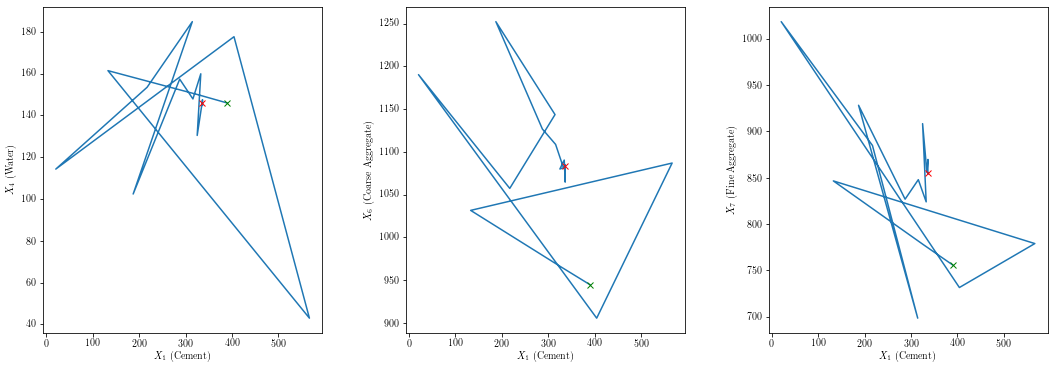

In [541]:
#pair_plot_optimised(accumulated_unscaled,path='./Figs/',name='pair_plot_optimised')
pair_plot_optimised(tmp2)

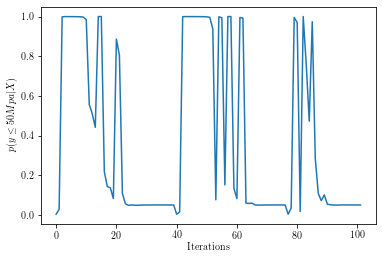

In [508]:
# checking inequility constraint is satisfied or not
cdf_opt = []
for i in range(accumulated.shape[0]):
    cdf_opt.append(cons_f(accumulated[i,:]))

plt.plot(cdf_opt)
plt.xlabel('Iterations')
plt.ylabel('$p(y\leq 50 Mpa|X)$')
path='./Figs/'
name='inequality_constraint_optimisation_trust'
#plt.savefig(path + name +datetime,format='pdf')

In [254]:
# optimisation 1
tmp1 = accumulated_unscaled[:,0]

In [262]:
tmp2 = accumulated_unscaled[:,0]

In [273]:
tmp3 = accumulated_unscaled[:,0]

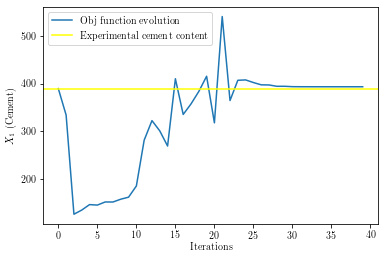

In [398]:
plt.plot(accumulated_unscaled[:,0], label ='Obj function evolution')
#plt.plot(tmp2)
#plt.plot(tmp3)
plt.axhline(y=np.array(xtest)[2,0],color='yellow',label='Experimental cement content')
plt.ylabel('$X_1$ (Cement)')
plt.xlabel('Iterations')
plt.legend()
path='./Figs/'
name='Obective_evolution_optimisation_trust'
#plt.savefig(path + name +datetime,format='pdf')

In [351]:
torch.tensor(accumulated[-1,0])

tensor(0.2598, dtype=torch.float64)

In [414]:
X_star = torch.hstack((torch.tensor(accumulated[-1,0]),xtest_scl[2,1],xtest_scl[2,2],torch.tensor(accumulated[-1,1]),xtest_scl[2,4],torch.tensor(accumulated[-1,2]),torch.tensor(accumulated[-1,3]),xtest_scl[2,7]))
y_star,v = gpr(torch.unsqueeze(X_star,0), full_cov =True, noiseless = False)

In [357]:
# the 52.5 strength class
y_star_walz = 52.5*(2.587-4.109*(np.array(accumulated_unscaled[-1,1])/np.array(accumulated_unscaled[-1,0]))+1.873*(np.array(accumulated_unscaled[-1,1])/np.array(accumulated_unscaled[-1,0]))**2)

In [362]:
v

tensor([[41.4466]], dtype=torch.float64, grad_fn=<AsStridedBackward>)

Text(0, 0.5, 'Compressive Strength')

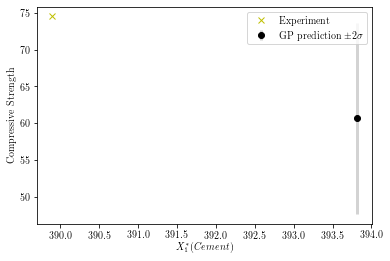

In [415]:
x_c_star = accumulated_unscaled[-1,0]
test_exp_no = 2

plt.plot(np.array(xtest)[2,0],np.array(ytest)[test_exp_no],'yx', label = 'Experiment')
#plt.plot(x_c_star,y_star_walz,'g*',label='Walz curve pred')
#plt.plot(x_c_star,y_star.detach().numpy(),'r*')
plt.errorbar(x_c_star,y_star.detach().numpy(),yerr=2*np.sqrt(v[0].detach().numpy()),fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, label ='GP prediction $\pm 2 \sigma$')
plt.legend()
plt.xlabel('$X_1^* (Cement)$')
plt.ylabel('Compressive Strength')
#plt.savefig('./Figs/Y_star_for_x_star_trust_'+datetime,format='pdf')

### Extra plots
We dont care about X_2 and X_3 and we should only care about X8 = 28. We can define 5 grid of values from X_5
3) For each of the values above solve the  the optimization problem as you have done (perhaps by adding \sigma_n^2 in the predictive variance).

4) Plot each of X_5 values vs optimal X_1 values identified by the optimization.

5) Plot optimal X_1 values (in parentheses the corresponding X_5 values) vs  GP-predicted compr. strength at the optimum plus/minus predictive st. deviation

Finally, check that the compr. strength at the optimum as predicted by the GP with the actual compr. strengths of data-points with X-values near the optimum. I don't know what the best way would be to plot this.  To determine closeness you have to first rescale the axes.

In [777]:
# Choosing the index which satisfying the above consitions
#idx_ = np.intersect1d(np.where((np.array(xtest['age'])==np.log(28)) & (np.array(xtest['water'])/np.array(xtest['cement'])<1)),np.where((np.array(xtest['blast_furnace_slag']) == 0) & (np.array(xtest['fly_ash'])==0)))
idx_ = np.intersect1d(np.where((np.array(x['age'])==np.log(28)) & (np.array(x['water'])/np.array(x['cement'])<1)),np.where((np.array(x['blast_furnace_slag']) == 0) & (np.array(x['fly_ash'])==0)))

In [786]:
xtmp =np.array(x)[idx_]
ytmp =np.array(y)[idx_]

In [787]:
xtest_plot = torch.tensor(xtmp[[-1,-2,-3,-6,-8],:])
ytest_plot = torch.tensor(ytmp[[-1,-2,-3,-6,-8]]) # tensor([39.0600, 25.1000, 44.8700, 39.0500, 39.0900]

In [788]:
xtest_plot

tensor([[ 374.3000,    0.0000,    0.0000,  190.2000,    6.7000, 1013.2000,
          730.4000,    3.3322],
        [ 312.7000,    0.0000,    0.0000,  178.1000,    8.0000,  999.7000,
          822.2000,    3.3322],
        [ 336.5000,    0.0000,    0.0000,  181.9000,    3.4000,  985.8000,
          816.8000,    3.3322],
        [ 374.0000,    0.0000,    0.0000,  190.0000,    7.0000, 1013.0000,
          730.0000,    3.3322],
        [ 397.0000,    0.0000,    0.0000,  185.0000,    0.0000, 1040.0000,
          734.0000,    3.3322]], dtype=torch.float64)

In [781]:
xtest_plot_scaled = scalar.transform(xtest_plot)

In [790]:
# perform optimisation for the six cases
res = []
accu = []
for i in range(xtest_plot.shape[0]):
    tmp1,tmp2 = run_minimization_problem(xtest_plot_scaled[i,:],30)
    res.append(tmp1)
    accu.append(tmp2)


`gtol` termination condition is satisfied.
Number of iterations: 25, function evaluations: 17, CG iterations: 33, optimality: 1.24e-09, constraint violation: 6.94e-18, execution time:  1.5 s.
`gtol` termination condition is satisfied.
Number of iterations: 26, function evaluations: 18, CG iterations: 39, optimality: 3.15e-10, constraint violation: 6.94e-18, execution time:  1.5 s.
`gtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 23, CG iterations: 49, optimality: 5.19e-09, constraint violation: 1.39e-17, execution time:  1.7 s.
`gtol` termination condition is satisfied.
Number of iterations: 26, function evaluations: 17, CG iterations: 35, optimality: 1.39e-09, constraint violation: 6.94e-18, execution time:  1.2 s.
`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 15, CG iterations: 27, optimality: 4.91e-09, constraint violation: 6.94e-18, execution time:  1.1 s.


In [791]:
x_opt_scaled =np.array([i.x for i in res])

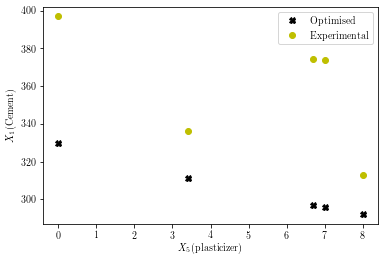

In [792]:
# X_1 vs X_5
plt.plot(xtest_plot[:,4],np.array((accu[0][-1,0],accu[1][-1,0],accu[2][-1,0],accu[3][-1,0],accu[4][-1,0])),'kX',label='Optimised')
plt.plot(xtest_plot[:,4],xtest_plot[:,0],'yo',label='Experimental')
plt.xlabel('$X_5$(plasticizer)')
plt.ylabel('$X_1$(Cement)')
plt.legend()
plt.savefig('./Figs/X1_vs_X5'+datetime,format='pdf')

In [697]:
# X_1 vs y (compressive strength)
X_star = torch.cat((torch.tensor(x_opt_scaled[:,0].reshape(-1,1)),xtest_plot_scaled[:,1].reshape(-1,1),xtest_plot_scaled[:,2].reshape(-1,1),torch.tensor(x_opt_scaled[:,1].reshape(-1,1)),xtest_plot_scaled[:,4].reshape(-1,1),torch.tensor(x_opt_scaled[:,2].reshape(-1,1)),torch.tensor(x_opt_scaled[:,3].reshape(-1,1)),xtest_plot_scaled[:,7].reshape(-1,1)),dim=1)
y_star,v = gpr(X_star, full_cov =True, noiseless = False)

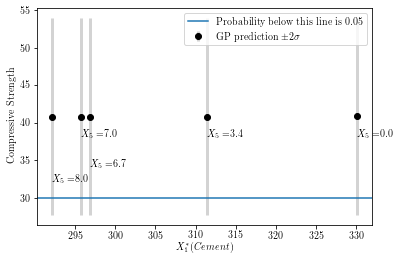

In [756]:

x_c_star = np.array((accu[0][-1,0],accu[1][-1,0],accu[2][-1,0],accu[3][-1,0],accu[4][-1,0]))
#plt.plot(x_c_star,y_star.detach().numpy(),'kx', label = 'GP')
sd =v.diag().sqrt()
#plt.fill_between(x_c_star,  # plot the two-sigma uncertainty about the mean
#                 (y_star - 2.0 * sd).detach().numpy(),
##                 color='black', alpha=0.1, label="$\pm 2 \sigma$")
#plt.plot(xtest_plot[:,0],ytest_plot,'yo')
plt.errorbar(x_c_star,y_star.detach().numpy(),yerr=2*sd.detach().numpy(),fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, label ='GP prediction $\pm 2 \sigma$')
plt.axhline(y=30,label='Probability below this line is 0.05')
plt.legend()
plt.annotate(s='$X_5 =$'+f'{xtest_plot[0,4]}',xy=[x_c_star[0],34])
plt.annotate(s='$X_5 =$'+f'{xtest_plot[1,4]}',xy=[x_c_star[1],32])
plt.annotate(s='$X_5 =$'+f'{xtest_plot[2,4]}',xy=[x_c_star[2],38])
plt.annotate(s='$X_5 =$'+f'{xtest_plot[3,4]}',xy=[x_c_star[3],38])
plt.annotate(s='$X_5 =$'+f'{xtest_plot[4,4]}',xy=[x_c_star[4],38])




plt.xlabel('$X_1^* (Cement)$')
plt.ylabel('Compressive Strength')
plt.savefig('./Figs/X_1 vs compressive_strength_wrtX5'+datetime,format='pdf')

In [811]:
ytest_plot

tensor([39.0600, 25.1000, 44.8700, 39.0500, 39.0900], dtype=torch.float64)

In [797]:
X_star

tensor([[ 0.1152, -0.8553, -0.8169, -2.6414,  0.0949,  2.2349,  1.2830,  0.1113],
        [ 0.0716, -0.8553, -0.8169, -2.6459,  0.3100,  2.2445,  1.3262,  0.1113],
        [ 0.2489, -0.8553, -0.8169, -2.6174, -0.4513,  2.1966,  1.1524,  0.1113],
        [ 0.1047, -0.8553, -0.8169, -2.6426,  0.1445,  2.2374,  1.2934,  0.1113],
        [ 0.4214, -0.8553, -0.8169, -2.5706, -1.0140,  2.1370,  0.9831,  0.1113]],
       dtype=torch.float64)

In [801]:
dist = []
for i in range(xtmp.shape[0]):
    dist.append(np.linalg.norm(X_star[0,:] - scalar.transform(torch.tensor(xtmp))[i,:]))
#dist = np.sort(dist)
idx_sorted = np.argsort(dist)

In [755]:
np.linalg.norm(X_star[0,:] - scalar.transform(torch.tensor(xtmp))[idx,:])

2.479235965740409

In [806]:
np.array(ytmp)[idx_sorted[3]]

20.87

In [810]:
np.array(xtmp)[idx_sorted[0]]

array([ 485.        ,    0.        ,    0.        ,  146.        ,
          0.        , 1120.        ,  800.        ,    3.33220451])

In [732]:
accu[0][-1,:]

tensor([ 296.8857,  125.9583, 1149.1361,  874.3713], dtype=torch.float64)

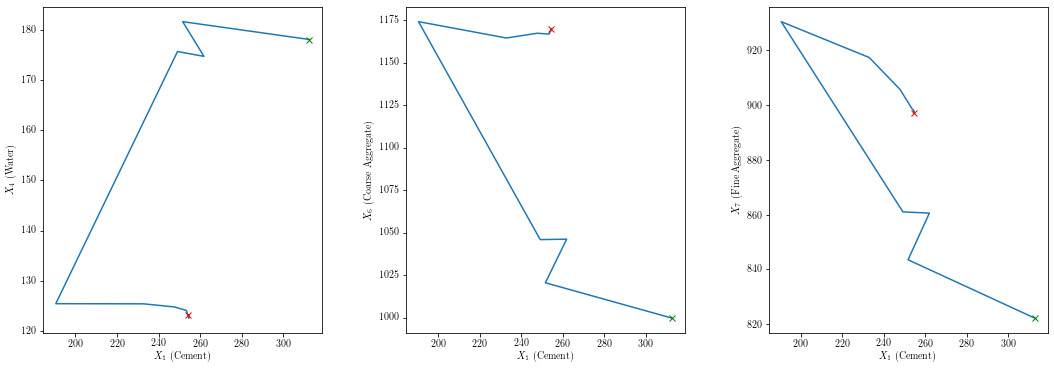

In [650]:
pair_plot_optimised(accu[1])

---
### misc codes

In [ ]:
tmp = kernel.forward(torch.tensor(xtest_scl))

In [ ]:
np.shape(xtest_scl)[0]

In [ ]:
n_test = np.shape(xtest_scl)[0]
noise = gpr.noise
cov = kernel.forward(torch.tensor(xtest_scl)) + noise.expand(n_test).diag()
samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)#.sample(sample_shape=(2,))
#plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)


In [ ]:
pyro.distributions.LogNormal(0,1).rsample([5])

In [ ]:
sb.pairplot(pd.DataFrame(z.detach().numpy()[:,:5]))

In [ ]:
x = pyro.sample("x", dist.Normal(torch.zeros(2), 1).to_event(1))


In [412]:
gpr(torch.unsqueeze(xtest_scl[2,:],0), full_cov =True, noiseless = False)

(tensor([67.3228], dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([[40.9569]], dtype=torch.float64, grad_fn=<AsStridedBackward>))

In [408]:
for p in gpr.parameters():
    print(p)

Parameter containing:
tensor(3.6637, requires_grad=True)
Parameter containing:
tensor([0.8899, 1.2422, 1.4895, 1.4623, 1.6577, 1.9022, 1.6573, 0.8225],
       requires_grad=True)
Parameter containing:
tensor(3.3656, requires_grad=True)
